# Natural Language Processing

O objetivo deste notebook é a criação de um modelo de Machine Learning de análise de sentimento (classificação) utilizado o processamento de linguagem natural. O modelo irá classificar os comentários em três classes: "Positivo", "Negativo" e "Neutro". O conjunto de comentários negativos possui um alto valor de informação para empresas, podendo ser utilizado como feedback de melhoria e/ou base de dados para análise de causa raiz. 

## 1. Importando Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import spacy
from nltk import tokenize, RSLPStemmer, FreqDist, tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.lm import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, make_scorer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from string import punctuation
from time import time
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from gensim.models.word2vec import Word2Vec
from collections import defaultdict
from yellowbrick.classifier import ROCAUC
from sklearn.preprocessing import LabelEncoder
from yellowbrick.classifier import PrecisionRecallCurve


from utils.regex_utils import *
from utils.stopword_utils import RemoverStopwords
from utils.normalize_utils import ProcessoNormalizacao
from utils.stemming_utils import ProcessoStemming
from utils.n_grams_utils import ngrams_count
from utils.wordcloud_utils import nuvem_palavras
from utils.select_model_utils import print_score_BayesSearchCV, print_score
from utils.features_extract import ExtracaoFeatures, E2V_IDF, extract_features_from_corpus, cut_off
from utils.word2vec_utils import E2V_IDF

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Leitura dos dados

O projeto foi desenvolvido utilizado um conjunto de dados público de e-commerce brasileiro de pedidos feitos na Olist Store, a maior loja de departamentos dos marketplaces brasileiros. A Olist conecta pequenas empresas de todo o Brasil a canais sem complicações e com um único contrato. Esses comerciantes podem vender seus produtos através da Olist Store e enviá-los diretamente aos clientes usando os parceiros de logística da Olist. O dataset possui informações de 100 mil pedidos de 2016 a 2018 feitos em vários marketplaces no Brasil. 

A base de dados de reviews foi construída a partir compras de produtos por clientes na Olist Store. Assim que o cliente recebe o produto, ou vence a data prevista de entrega, o cliente recebe uma pesquisa de satisfação por e-mail onde pode dar uma nota da experiência de compra e anotar alguns comentários.

In [2]:
dataset = pd.read_csv('datasets/order_reviews.csv', sep=';')

In [4]:
dataset.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

## 3. Compreensão de dados

### 3.1. Analise de dados faltantes (Null)

In [3]:
dataset.drop(['review_id', 'review_creation_date', 'review_answer_timestamp', 'review_comment_title', 'order_id'], axis=1, inplace=True)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            99224 non-null  int64 
 1   review_comment_message  40977 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [4]:
# Retirando o valores Null de reviews
dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True)
dataset.shape

(40977, 2)

In [8]:
dataset.head()

review_score                             review_comment_message
0             5              Recebi bem antes do prazo estipulado.
1             5  Parabéns lojas lannister adorei comprar pela I...
2             4  aparelho eficiente. no site a marca do aparelh...
3             4    Mas um pouco ,travando...pelo valor ta Boa.\r\n
4             5  Vendedor confiável, produto ok e entrega antes...

### 3.1. Rotulagem dos dados

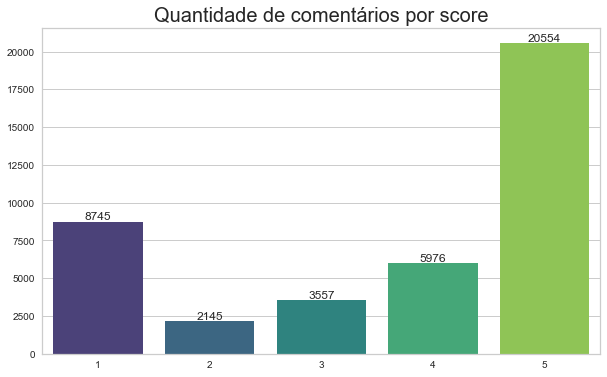

In [8]:
# Criando um datafrem que contem as quantidade de acordo com o score
quantidade = pd.DataFrame(dataset['review_score'].value_counts()).sort_index()

# plotando o gráfico de barra
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(y='review_score', x=quantidade.index, data=quantidade, orient='v', palette='viridis')
ax.set_title('Quantidade de comentários por score', fontdict={'fontsize': 20})
ax.set(ylabel=None, xlabel=None)
ax.bar_label(ax.containers[0])
plt.show()

Com objetivo de criar um modelo de análise sentimental em uma abordagem de Machine Learning supervisionado, iremos dividir os sentimentos em três classes: negativo, neutro e positivo. O database não possui uma definição explicita sobre a definição de sentimento para cada comentário. Pensando em uma implementação rápida, utilizaremos a coluna "review_score" para rotular os dados nas três classes já que ela dá uma uma ideia sobre a satisfação do cliente a respeito da compra.

Rotulagem dos dados:
- Positivo (1): Compreende os scores de valores 4 e 5
- Neutro (0): Compreende o score de valor 3
- Negativo (-1): Compreende os scores de valores 1 e 2


In [9]:
# Rotulagem dos dados
score_map = {
    1: -1,
    2: -1,
    3: 0,
    4: 1,
    5: 1
}

dataset['sentiment_label'] = dataset['review_score'].map(score_map)
dataset = dataset[['review_score', 'sentiment_label','review_comment_message']]

In [10]:
dataset.head()

review_score  sentiment_label  \
0             5                1   
1             5                1   
2             4                1   
3             4                1   
4             5                1   

                              review_comment_message  
0              Recebi bem antes do prazo estipulado.  
1  Parabéns lojas lannister adorei comprar pela I...  
2  aparelho eficiente. no site a marca do aparelh...  
3    Mas um pouco ,travando...pelo valor ta Boa.\r\n  
4  Vendedor confiável, produto ok e entrega antes...

In [11]:
dataset['sentiment_label'].value_counts()

 1    26530
-1    10890
 0     3557
Name: sentiment_label, dtype: int64

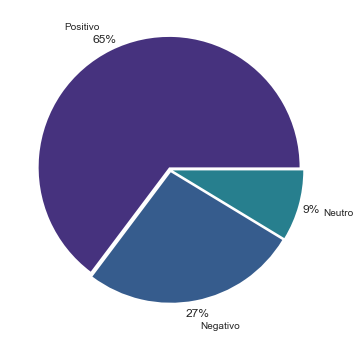

In [12]:
sentiment = pd.DataFrame(dataset['sentiment_label'].value_counts())
labels = ['Positivo', 'Negativo', 'Neutro']

fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('viridis')
ax.pie(sentiment['sentiment_label'],labels= labels,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, explode = [0.02, 0.02, 0.02], colors=colors)
plt.show()

## 4. Criando uma BaseLine

Iremos definir uma baseline para o modelo de classificação de sentimos supervisionado. A baseline é um modelo simples de previsão que atua como referência para futuros modelos de Machine Learning, algumas informações aqui descritas serão explicadas e demostradas ao longo do projeto.

### 4.1. Bag of Words: criando representações da linguagem humana.

In [13]:
# Vetorizando as 50 palavras com mais ocorrência da coluna "review_comment_message"
vetorizar = CountVectorizer(max_features=50)
bag_of_words = vetorizar.fit_transform(dataset['review_comment_message'])
bag_of_words.shape

(40977, 50)

In [14]:
# Visualização das 50 palavras com mais ocorrência
print(vetorizar.get_feature_names_out())

['ainda' 'antes' 'as' 'até' 'bem' 'bom' 'chegou' 'com' 'como' 'compra'
 'comprei' 'da' 'de' 'dentro' 'do' 'em' 'entrega' 'entregue' 'estou' 'eu'
 'excelente' 'foi' 'gostei' 'loja' 'mais' 'mas' 'me' 'meu' 'minha' 'muito'
 'na' 'no' 'não' 'os' 'para' 'por' 'prazo' 'produto' 'qualidade' 'que'
 'recebi' 'recomendo' 'rápida' 'super' 'só' 'tudo' 'um' 'uma' 'veio'
 'ótimo']


### 4.2. Modelo: LogisticRegression 

In [16]:
regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial')
scorer = make_scorer(f1_score, average = 'weighted')
scores = cross_val_score(regressao_logistica, bag_of_words, dataset['sentiment_label'], cv=10, scoring=scorer)
print(f'f1_score:{np.sort(scores)}')
print(f'Média: {scores.mean()}')
print(f'Desvio Padrão: {scores.std()}')

f1_score:[0.7567944  0.75861866 0.75916878 0.7594724  0.76023611 0.76070996
 0.76244324 0.76274105 0.77094021 0.77662594]
Média: 0.7627750743117272
Desvio Padrão: 0.005884688391941579


#### 4.2.1. Matriz de confusão

A matriz de confusão é a forma mais simples de analisar o desempenho de um algoritmo de classificação, sendo base para os cáculo das métricas dela derivadas.  

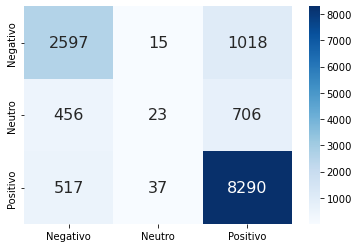

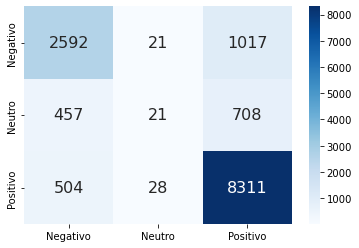

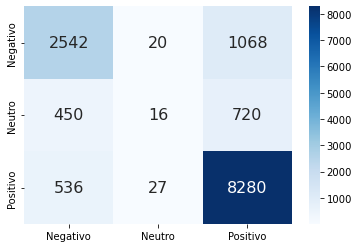

In [54]:
X = bag_of_words
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)
i = 1

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial')

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=['Negativo', 'Neutro', 'Positivo'], columns=['Negativo', 'Neutro', 'Positivo'])
    plt.figure(i)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g')
    i += i
    

#### 4.2.2. Precisão e Revocação

A métrica precisão do classificador (precision_score) é a acurácia das previsões positivas, ou seja, todos os dados classificados como positivos, quantos são realmente positivos. O melhor valor é 1 e o pior valor é 0.

$$ precisão = \frac {TP}{TP + FP} $$

- TP: número de verdadeiros positivos
- FP: número de falsos positivos

A precisão é utilizada em conjunto com outra métrica chamada revocação (recall_score), também conhecida como sensibilidade ou taxa de verdadeiros positivos (TPR, do inglês): esta é a taxa de instâncias positivas que são corretamente detectadas pelo classificador.

$$ revocacão = \frac {TP}{TP + FN} $$

- TP: número de verdadeiros positivos
- FN: número de falsos negativos

#### 4.2.3. Pontuação F1

Uma forma simples de comparar dois classificadores é através da métrica chamada pontuação (F1). A pontuação F1 é a média harmônica da precisão e revocação. Enquanto a média regular trata igualmente todos os valores, a média harmônica dá muito mais peso aos valores mais baixos. Como resultado, o classificador só obterá uma pontuação F1 alta se a revocação e a precisão forem altas.

$$F_1 = \frac {2}{\frac {1}{precisão} + \frac {1}{revocacão}} = \frac {precisão * revocacão} {precisão + revocacão} = \frac {TP} {TP + \frac {FN + FP} {2}} $$

#### 4.2.4. Analise precisão, revocação e pontuação (f1) para cada classe:

In [52]:
# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial')

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.7641533151796949
              precision    recall  f1-score   support

    negativo       0.73      0.72      0.72      3630
      neutro       0.31      0.02      0.04      1185
    positivo       0.83      0.94      0.88      8844

    accuracy                           0.80     13659
   macro avg       0.62      0.56      0.55     13659
weighted avg       0.76      0.80      0.76     13659

f1_score: 0.7647160778158226
              precision    recall  f1-score   support

    negativo       0.73      0.71      0.72      3630
      neutro       0.30      0.02      0.03      1186
    positivo       0.83      0.94      0.88      8843

    accuracy                           0.80     13659
   macro avg       0.62      0.56      0.55     13659
weighted avg       0.76      0.80      0.76     13659

f1_score: 0.7578329397156042
              precision    recall  f1-score   support

    negativo       0.72      0.70      0.71      3630
      neutro       0.25      0.01      0.0

## 5. Estrutura do Pipeline de transformação dos dados

Será utilizado a classe Pipeline do Scikit Learn para executar uma preparação dos textos de cada comentário de forma automática, deixando pronto para treinamento e previsão do rótulo de sentimento. As etapas do pipeline são:

- Remoção das expressões regulares: sabendo que os dados são fruto de comentários da internet, será necessário lidar com algumas expressões regulares. Iremos realizar o pré-processamento dos dados, substituído as expressões regulares por termos que as caracterizem de forma simples;

- Remoção de StopWords: As stopwords são palavras que não apresentam relevância em determinado contexto e podem ser removidas sem perda semântica da frase;

- Normalização dos comentários: pega os dados Unicode e tenta representá-los em caracteres ASCII (ou seja, os caracteres universalmente exibíveis entre 0x00 e 0x7F), onde os compromissos assumidos ao mapear entre dois conjuntos de caracteres são escolhidos para estar perto do que um humano com um teclado americano escolheria;

- Stemming: Stemming é a técnica que transforma as flexões de uma palavra em um núcleo comum (tronco).  Essa técnica normaliza as palavras de forma a evitar suas flexões e derivações. Existem diversos algoritmos para realizar a “stemmização", seja em Português, sejam em outros idiomas;

- Extração de features: A extração de features de texto envolve resumir automaticamente o texto e encontrar palavras importantes. A extração de palavras poderá ser feita de duas formas:
    - CountVectorizer: converte uma coleção de documentos de texto em uma matriz de contagens de token, ou seja, produz uma representação esparsa das contagens de frequência das palavras ao longo de todo o dataset;
    - TF-IDF (Term Frequency-Inverse Document Frequency): é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico.  O TF-IDF irá contar a frequência das palavras e atribui pesos as mesmas, ponderando-as em todo o dataset. Se uma palavra aparece muitas vezes, ela perde o poder de diferenciação, logo, possuirá um peso menor.


Todas as etapas do Pipeline foram modularizadas no diretório utils para tornar o programa mais "limpo".

In [5]:
# Definindo todas as trafomações regex para serem aplicadas ao pipeline
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}

# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('stemming', ProcessoStemming(RSLPStemmer()))
])

# Dfinido X e y 
comentarios = dataset['review_comment_message'].dropna().index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

# Dfinido X e y 
X = list(dataset['review_comment_message'][comentarios].values)
y = score.values

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

In [6]:
dataset = dataset[dataset['review_comment_message'].notna()]
dataset['review_stemming'] = X_processed
dataset

review_score  \
0                 5   
1                 5   
2                 4   
3                 4   
4                 5   
...             ...   
40972             4   
40973             5   
40974             3   
40975             5   
40976             1   

                                                                                                                                                               review_comment_message  \
0                                                                                                                                               Recebi bem antes do prazo estipulado.   
1                                                                                Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa   
2      aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho   
3                                                                                                                                     Mas um pouco ,travando...pelo valor ta Boa.\r\n   
4                                                                                                                            Vendedor confiável, produto ok e entrega antes do prazo.   
...                                                                                                                                                                               ...   
40972                                                                                                                      para este produto recebi de acordo com a compra realizada!   
40973                                                                                     Entregou dentro do prazo. O produto chegou em condições perfeitas. Estou muito satisfeita!    
40974                                                   O produto não foi enviado com NF, não existe venda sem NF, com certeza fico no aguardo do envio da NF podendo ser por e-mail.   
40975                                                                                                             Excelente mochila, entrega super rápida. Super recomendo essa loja!   
40976                                                                                           meu produto chegou e ja tenho que devolver, pois está com defeito , não segurar carga   

                                                                                         review_stemming  
0                                                                             receb bem ant praz estipul  
1                                  parab loj lannist ador compr internet segur pra parab tod feliz pasco  
2      aparelh efici sit marc aparelh impress numer desinfec cheg outr nom atual marc corret vez aparelh  
3                                                                                   pouc trav val ta boa  
4                                                                  vend confia produt ok entreg ant praz  
...                                                                                                  ...  
40972                                                                    produt receb acord compr realiz  
40973                                            entreg dentr praz produt cheg condico perfeit satisfeit  
40974                        produt negaca envi nf negaca exist vend nf cert fic aguard envi nf pod mail  
40975                                                          excel mochil entreg sup rap sup recom loj  
40976                                                 produt cheg ja devolv poi defeit negaca segur carg  

[40977 rows x 3 columns]

## 6. Extração de features

In [6]:
# Função para verificar a f1_score para um conjunto de hiperparâmentros de vetorização
def print_classification_report(X, y):
    # Cria 3 partições com os dados de disponíveis
    skf = StratifiedKFold(n_splits=3)
    skf.get_n_splits(X, y)


    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #Criação do modelo
        regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', random_state=42, max_iter=200)

        regressao_logistica.fit(X_train, y_train)
        y_true, y_pred = y_test, regressao_logistica.predict(X_test)
        score = f1_score(y_true, y_pred, average='weighted')
        print(f'f1_score: {score}')
        print(classification_report(y_true, y_pred))

### 6.1. CountVectorizer

O CountVectorizer converte uma coleção de documentos de texto em uma matriz de contagens de token, ou seja, essa implementação produz uma representação esparsa das contagens de frequência das palavras ao longo de todo o dataset.

#### 6.1.1. N-grams

In [9]:
# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = CountVectorizer(min_df=15)     # , stop_words=stop_words
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['review_stemming'], vectorizer, df=True)
y = dataset['review_score'].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})
print(f'Shape: {df_corpus_features.shape}')
df_corpus_features

Shape: (40977, 1208)


abaix  abert  abr  abrac  abril  absurd  acab  aceit  acert  acess  \
0          0      0    0      0      0       0     0      0      0      0   
1          0      0    0      0      0       0     0      0      0      0   
2          0      0    0      0      0       0     0      0      0      0   
3          0      0    0      0      0       0     0      0      0      0   
4          0      0    0      0      0       0     0      0      0      0   
...      ...    ...  ...    ...    ...     ...   ...    ...    ...    ...   
40972      0      0    0      0      0       0     0      0      0      0   
40973      0      0    0      0      0       0     0      0      0      0   
40974      0      0    0      0      0       0     0      0      0      0   
40975      0      0    0      0      0       0     0      0      0      0   
40976      0      0    0      0      0       0     0      0      0      0   

       ...  vist  viv  voc  volt  volum  vou  whey  xl  zer  zip  
0      ...     0    0    0     0      0    0     0   0    0    0  
1      ...     0    0    0     0      0    0     0   0    0    0  
2      ...     0    0    0     0      0    0     0   0    0    0  
3      ...     0    0    0     0      0    0     0   0    0    0  
4      ...     0    0    0     0      0    0     0   0    0    0  
...    ...   ...  ...  ...   ...    ...  ...   ...  ..  ...  ...  
40972  ...     0    0    0     0      0    0     0   0    0    0  
40973  ...     0    0    0     0      0    0     0   0    0    0  
40974  ...     0    0    0     0      0    0     0   0    0    0  
40975  ...     0    0    0     0      0    0     0   0    0    0  
40976  ...     0    0    0     0      0    0     0   0    0    0  

[40977 rows x 1208 columns]

In [10]:
print_classification_report(corpus_features, y)

c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


f1_score: 0.8167986628706808
              precision    recall  f1-score   support

    negativo       0.78      0.82      0.80      3630
      neutro       0.29      0.10      0.15      1185
    positivo       0.89      0.94      0.91      8844

    accuracy                           0.84     13659
   macro avg       0.65      0.62      0.62     13659
weighted avg       0.81      0.84      0.82     13659



c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


f1_score: 0.8138136210023467
              precision    recall  f1-score   support

    negativo       0.77      0.83      0.80      3630
      neutro       0.25      0.09      0.13      1186
    positivo       0.89      0.94      0.91      8843

    accuracy                           0.84     13659
   macro avg       0.64      0.62      0.61     13659
weighted avg       0.80      0.84      0.81     13659



c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


f1_score: 0.816987391665645
              precision    recall  f1-score   support

    negativo       0.77      0.83      0.80      3630
      neutro       0.30      0.10      0.15      1186
    positivo       0.89      0.94      0.91      8843

    accuracy                           0.84     13659
   macro avg       0.65      0.62      0.62     13659
weighted avg       0.81      0.84      0.82     13659



In [12]:
# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = CountVectorizer(min_df=15, ngram_range=(2,2))     # , stop_words=stop_words
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['review_stemming'], vectorizer, df=True)
y = dataset['review_score'].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})
print(f'Shape: {df_corpus_features.shape}')
df_corpus_features

Shape: (40977, 1877)


abr caix  abr embal  abr reclamaca  acab negaca  acab perfeit  \
0             0          0              0            0             0   
1             0          0              0            0             0   
2             0          0              0            0             0   
3             0          0              0            0             0   
4             0          0              0            0             0   
...         ...        ...            ...          ...           ...   
40972         0          0              0            0             0   
40973         0          0              0            0             0   
40974         0          0              0            0             0   
40975         0          0              0            0             0   
40976         0          0              0            0             0   

       ach demor  ach dev  ach entreg  ach falt  ach fret  ...  vou avali  \
0              0        0           0         0         0  ...          0   
1              0        0           0         0         0  ...          0   
2              0        0           0         0         0  ...          0   
3              0        0           0         0         0  ...          0   
4              0        0           0         0         0  ...          0   
...          ...      ...         ...       ...       ...  ...        ...   
40972          0        0           0         0         0  ...          0   
40973          0        0           0         0         0  ...          0   
40974          0        0           0         0         0  ...          0   
40975          0        0           0         0         0  ...          0   
40976          0        0           0         0         0  ...          0   

       vou compr  vou continu  vou devolv  vou faz  vou fic  vou receb  \
0              0            0           0        0        0          0   
1              0            0           0        0        0          0   
2              0            0           0        0        0          0   
3              0            0           0        0        0          0   
4              0            0           0        0        0          0   
...          ...          ...         ...      ...      ...        ...   
40972          0            0           0        0        0          0   
40973          0            0           0        0        0          0   
40974          0            0           0        0        0          0   
40975          0            0           0        0        0          0   
40976          0            0           0        0        0          0   

       vou recomend  vou ter  vou test  
0                 0        0         0  
1                 0        0         0  
2                 0        0         0  
3                 0        0         0  
4                 0        0         0  
...             ...      ...       ...  
40972             0        0         0  
40973             0        0         0  
40974             0        0         0  
40975             0        0         0  
40976             0        0         0  

[40977 rows x 1877 columns]

In [13]:
print_classification_report(corpus_features, y)

c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


f1_score: 0.7966339658023792
              precision    recall  f1-score   support

    negativo       0.79      0.75      0.77      3630
      neutro       0.32      0.07      0.12      1185
    positivo       0.85      0.96      0.90      8844

    accuracy                           0.82     13659
   macro avg       0.65      0.59      0.60     13659
weighted avg       0.79      0.82      0.80     13659



c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


f1_score: 0.7963096448498523
              precision    recall  f1-score   support

    negativo       0.80      0.75      0.77      3630
      neutro       0.26      0.05      0.09      1186
    positivo       0.85      0.96      0.90      8843

    accuracy                           0.83     13659
   macro avg       0.64      0.59      0.59     13659
weighted avg       0.78      0.83      0.80     13659

f1_score: 0.7896278151253422
              precision    recall  f1-score   support

    negativo       0.78      0.73      0.76      3630
      neutro       0.26      0.06      0.10      1186
    positivo       0.84      0.95      0.90      8843

    accuracy                           0.82     13659
   macro avg       0.63      0.58      0.58     13659
weighted avg       0.78      0.82      0.79     13659



In [14]:
# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = CountVectorizer(min_df=15, ngram_range=(2,3))     # , stop_words=stop_words
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['review_stemming'], vectorizer, df=True)
y = dataset['review_score'].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})
print(f'Shape: {df_corpus_features.shape}')
df_corpus_features

Shape: (40977, 2584)


abr caix  abr embal  abr reclamaca  acab negaca  acab perfeit  \
0             0          0              0            0             0   
1             0          0              0            0             0   
2             0          0              0            0             0   
3             0          0              0            0             0   
4             0          0              0            0             0   
...         ...        ...            ...          ...           ...   
40972         0          0              0            0             0   
40973         0          0              0            0             0   
40974         0          0              0            0             0   
40975         0          0              0            0             0   
40976         0          0              0            0             0   

       ach demor  ach dev  ach entreg  ach falt  ach fret  ...  vou compr  \
0              0        0           0         0         0  ...          0   
1              0        0           0         0         0  ...          0   
2              0        0           0         0         0  ...          0   
3              0        0           0         0         0  ...          0   
4              0        0           0         0         0  ...          0   
...          ...      ...         ...       ...       ...  ...        ...   
40972          0        0           0         0         0  ...          0   
40973          0        0           0         0         0  ...          0   
40974          0        0           0         0         0  ...          0   
40975          0        0           0         0         0  ...          0   
40976          0        0           0         0         0  ...          0   

       vou continu  vou continu compr  vou devolv  vou faz  vou fic  \
0                0                  0           0        0        0   
1                0                  0           0        0        0   
2                0                  0           0        0        0   
3                0                  0           0        0        0   
4                0                  0           0        0        0   
...            ...                ...         ...      ...      ...   
40972            0                  0           0        0        0   
40973            0                  0           0        0        0   
40974            0                  0           0        0        0   
40975            0                  0           0        0        0   
40976            0                  0           0        0        0   

       vou receb  vou recomend  vou ter  vou test  
0              0             0        0         0  
1              0             0        0         0  
2              0             0        0         0  
3              0             0        0         0  
4              0             0        0         0  
...          ...           ...      ...       ...  
40972          0             0        0         0  
40973          0             0        0         0  
40974          0             0        0         0  
40975          0             0        0         0  
40976          0             0        0         0  

[40977 rows x 2584 columns]

In [15]:
print_classification_report(corpus_features, y)

c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


f1_score: 0.7961306690792892
              precision    recall  f1-score   support

    negativo       0.79      0.75      0.77      3630
      neutro       0.30      0.07      0.11      1185
    positivo       0.85      0.96      0.90      8844

    accuracy                           0.82     13659
   macro avg       0.65      0.59      0.59     13659
weighted avg       0.79      0.82      0.80     13659



c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


f1_score: 0.7942243858140999
              precision    recall  f1-score   support

    negativo       0.80      0.74      0.77      3630
      neutro       0.26      0.06      0.10      1186
    positivo       0.85      0.96      0.90      8843

    accuracy                           0.82     13659
   macro avg       0.63      0.59      0.59     13659
weighted avg       0.78      0.82      0.79     13659

f1_score: 0.7901343937984506
              precision    recall  f1-score   support

    negativo       0.78      0.73      0.76      3630
      neutro       0.27      0.06      0.10      1186
    positivo       0.84      0.95      0.90      8843

    accuracy                           0.82     13659
   macro avg       0.63      0.58      0.58     13659
weighted avg       0.78      0.82      0.79     13659



Dentre os valores de n-grams testados anteriormente para o CountVectorizer, o único que será testado será Uni-gram (1,1), pois foi o que obtive o melhor f1-score para classificação da classe 'neutro'. Os demais n-grams até obtiveram valores interessante de precisão (precision), mas a revocação (recall) foram valores muito baixos.


### 6.2. TfidfVectorizer

O valor TF-IDF (Term Frequency-Inverse Document Frequency), é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico.  O TF-IDF irá contar a frequência das palavras e atribui pesos as mesmas, ponderando-as em todo o dataset. Se uma palavra aparece muitas vezes, ela perde o poder de diferenciação, logo, possuirá um peso menor.


$$TF=\frac{\text{Frequency of a word in the document}}{\text{Total words in the document}}$$

$$IDF = \log\left({\frac{\text{Total number of docs}}{\text{Number of docs containing the words}}}\right)$$

#### 6.2.1. N-grams

Os modelos que estávamos utilizando até agora não gera um valor que preserve a sequência de palavras. O N-grams considera essencialmente uma sequência de palavras que aparecem na mesma "janela" ao mesmo tempo. Iremos testar modelos que com a utilização de N-grams:

In [16]:
# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15, ngram_range=(1,1))     # , stop_words=stop_words
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['review_stemming'], vectorizer, df=True)
y = dataset['review_score'].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})
print(f'Shape: {df_corpus_features.shape}')
df_corpus_features

Shape: (40977, 1208)


abaix  abert  abr  abrac  abril  absurd  acab  aceit  acert  acess  \
0        0.0    0.0  0.0    0.0    0.0     0.0   0.0    0.0    0.0    0.0   
1        0.0    0.0  0.0    0.0    0.0     0.0   0.0    0.0    0.0    0.0   
2        0.0    0.0  0.0    0.0    0.0     0.0   0.0    0.0    0.0    0.0   
3        0.0    0.0  0.0    0.0    0.0     0.0   0.0    0.0    0.0    0.0   
4        0.0    0.0  0.0    0.0    0.0     0.0   0.0    0.0    0.0    0.0   
...      ...    ...  ...    ...    ...     ...   ...    ...    ...    ...   
40972    0.0    0.0  0.0    0.0    0.0     0.0   0.0    0.0    0.0    0.0   
40973    0.0    0.0  0.0    0.0    0.0     0.0   0.0    0.0    0.0    0.0   
40974    0.0    0.0  0.0    0.0    0.0     0.0   0.0    0.0    0.0    0.0   
40975    0.0    0.0  0.0    0.0    0.0     0.0   0.0    0.0    0.0    0.0   
40976    0.0    0.0  0.0    0.0    0.0     0.0   0.0    0.0    0.0    0.0   

       ...  vist  viv  voc  volt  volum  vou  whey   xl  zer  zip  
0      ...   0.0  0.0  0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0  
1      ...   0.0  0.0  0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0  
2      ...   0.0  0.0  0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0  
3      ...   0.0  0.0  0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0  
4      ...   0.0  0.0  0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0  
...    ...   ...  ...  ...   ...    ...  ...   ...  ...  ...  ...  
40972  ...   0.0  0.0  0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0  
40973  ...   0.0  0.0  0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0  
40974  ...   0.0  0.0  0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0  
40975  ...   0.0  0.0  0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0  
40976  ...   0.0  0.0  0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0  

[40977 rows x 1208 columns]

In [17]:
print_classification_report(corpus_features, y)

f1_score: 0.8172838630767773
              precision    recall  f1-score   support

    negativo       0.76      0.86      0.81      3630
      neutro       0.35      0.07      0.11      1185
    positivo       0.89      0.94      0.92      8844

    accuracy                           0.84     13659
   macro avg       0.67      0.62      0.61     13659
weighted avg       0.81      0.84      0.82     13659

f1_score: 0.8164842963231064
              precision    recall  f1-score   support

    negativo       0.76      0.87      0.81      3630
      neutro       0.30      0.05      0.09      1186
    positivo       0.89      0.94      0.92      8843

    accuracy                           0.84     13659
   macro avg       0.65      0.62      0.61     13659
weighted avg       0.81      0.84      0.82     13659

f1_score: 0.8151780144623657
              precision    recall  f1-score   support

    negativo       0.75      0.87      0.81      3630
      neutro       0.34      0.06      0.1

In [18]:
# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15, ngram_range=(2,2))     # , stop_words=stop_words
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['review_stemming'], vectorizer, df=True)
y = dataset['review_score'].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})
print(f'Shape: {df_corpus_features.shape}')
df_corpus_features

Shape: (40977, 1877)


abr caix  abr embal  abr reclamaca  acab negaca  acab perfeit  \
0           0.0        0.0            0.0          0.0           0.0   
1           0.0        0.0            0.0          0.0           0.0   
2           0.0        0.0            0.0          0.0           0.0   
3           0.0        0.0            0.0          0.0           0.0   
4           0.0        0.0            0.0          0.0           0.0   
...         ...        ...            ...          ...           ...   
40972       0.0        0.0            0.0          0.0           0.0   
40973       0.0        0.0            0.0          0.0           0.0   
40974       0.0        0.0            0.0          0.0           0.0   
40975       0.0        0.0            0.0          0.0           0.0   
40976       0.0        0.0            0.0          0.0           0.0   

       ach demor  ach dev  ach entreg  ach falt  ach fret  ...  vou avali  \
0            0.0      0.0         0.0       0.0       0.0  ...        0.0   
1            0.0      0.0         0.0       0.0       0.0  ...        0.0   
2            0.0      0.0         0.0       0.0       0.0  ...        0.0   
3            0.0      0.0         0.0       0.0       0.0  ...        0.0   
4            0.0      0.0         0.0       0.0       0.0  ...        0.0   
...          ...      ...         ...       ...       ...  ...        ...   
40972        0.0      0.0         0.0       0.0       0.0  ...        0.0   
40973        0.0      0.0         0.0       0.0       0.0  ...        0.0   
40974        0.0      0.0         0.0       0.0       0.0  ...        0.0   
40975        0.0      0.0         0.0       0.0       0.0  ...        0.0   
40976        0.0      0.0         0.0       0.0       0.0  ...        0.0   

       vou compr  vou continu  vou devolv  vou faz  vou fic  vou receb  \
0            0.0          0.0         0.0      0.0      0.0        0.0   
1            0.0          0.0         0.0      0.0      0.0        0.0   
2            0.0          0.0         0.0      0.0      0.0        0.0   
3            0.0          0.0         0.0      0.0      0.0        0.0   
4            0.0          0.0         0.0      0.0      0.0        0.0   
...          ...          ...         ...      ...      ...        ...   
40972        0.0          0.0         0.0      0.0      0.0        0.0   
40973        0.0          0.0         0.0      0.0      0.0        0.0   
40974        0.0          0.0         0.0      0.0      0.0        0.0   
40975        0.0          0.0         0.0      0.0      0.0        0.0   
40976        0.0          0.0         0.0      0.0      0.0        0.0   

       vou recomend  vou ter  vou test  
0               0.0      0.0       0.0  
1               0.0      0.0       0.0  
2               0.0      0.0       0.0  
3               0.0      0.0       0.0  
4               0.0      0.0       0.0  
...             ...      ...       ...  
40972           0.0      0.0       0.0  
40973           0.0      0.0       0.0  
40974           0.0      0.0       0.0  
40975           0.0      0.0       0.0  
40976           0.0      0.0       0.0  

[40977 rows x 1877 columns]

In [19]:
print_classification_report(corpus_features, y)

f1_score: 0.8006786592020506
              precision    recall  f1-score   support

    negativo       0.78      0.79      0.78      3630
      neutro       0.39      0.04      0.08      1185
    positivo       0.86      0.96      0.90      8844

    accuracy                           0.83     13659
   macro avg       0.68      0.60      0.59     13659
weighted avg       0.80      0.83      0.80     13659

f1_score: 0.7991609477375718
              precision    recall  f1-score   support

    negativo       0.79      0.79      0.79      3630
      neutro       0.30      0.03      0.06      1186
    positivo       0.86      0.96      0.90      8843

    accuracy                           0.83     13659
   macro avg       0.65      0.59      0.58     13659
weighted avg       0.79      0.83      0.80     13659

f1_score: 0.792026642153476
              precision    recall  f1-score   support

    negativo       0.77      0.77      0.77      3630
      neutro       0.27      0.03      0.05

In [20]:
# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15, ngram_range=(2,3))     # , stop_words=stop_words
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['review_stemming'], vectorizer, df=True)
y = dataset['review_score'].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})
print(f'Shape: {df_corpus_features.shape}')
df_corpus_features

Shape: (40977, 2584)


abr caix  abr embal  abr reclamaca  acab negaca  acab perfeit  \
0           0.0        0.0            0.0          0.0           0.0   
1           0.0        0.0            0.0          0.0           0.0   
2           0.0        0.0            0.0          0.0           0.0   
3           0.0        0.0            0.0          0.0           0.0   
4           0.0        0.0            0.0          0.0           0.0   
...         ...        ...            ...          ...           ...   
40972       0.0        0.0            0.0          0.0           0.0   
40973       0.0        0.0            0.0          0.0           0.0   
40974       0.0        0.0            0.0          0.0           0.0   
40975       0.0        0.0            0.0          0.0           0.0   
40976       0.0        0.0            0.0          0.0           0.0   

       ach demor  ach dev  ach entreg  ach falt  ach fret  ...  vou compr  \
0            0.0      0.0         0.0       0.0       0.0  ...        0.0   
1            0.0      0.0         0.0       0.0       0.0  ...        0.0   
2            0.0      0.0         0.0       0.0       0.0  ...        0.0   
3            0.0      0.0         0.0       0.0       0.0  ...        0.0   
4            0.0      0.0         0.0       0.0       0.0  ...        0.0   
...          ...      ...         ...       ...       ...  ...        ...   
40972        0.0      0.0         0.0       0.0       0.0  ...        0.0   
40973        0.0      0.0         0.0       0.0       0.0  ...        0.0   
40974        0.0      0.0         0.0       0.0       0.0  ...        0.0   
40975        0.0      0.0         0.0       0.0       0.0  ...        0.0   
40976        0.0      0.0         0.0       0.0       0.0  ...        0.0   

       vou continu  vou continu compr  vou devolv  vou faz  vou fic  \
0              0.0                0.0         0.0      0.0      0.0   
1              0.0                0.0         0.0      0.0      0.0   
2              0.0                0.0         0.0      0.0      0.0   
3              0.0                0.0         0.0      0.0      0.0   
4              0.0                0.0         0.0      0.0      0.0   
...            ...                ...         ...      ...      ...   
40972          0.0                0.0         0.0      0.0      0.0   
40973          0.0                0.0         0.0      0.0      0.0   
40974          0.0                0.0         0.0      0.0      0.0   
40975          0.0                0.0         0.0      0.0      0.0   
40976          0.0                0.0         0.0      0.0      0.0   

       vou receb  vou recomend  vou ter  vou test  
0            0.0           0.0      0.0       0.0  
1            0.0           0.0      0.0       0.0  
2            0.0           0.0      0.0       0.0  
3            0.0           0.0      0.0       0.0  
4            0.0           0.0      0.0       0.0  
...          ...           ...      ...       ...  
40972        0.0           0.0      0.0       0.0  
40973        0.0           0.0      0.0       0.0  
40974        0.0           0.0      0.0       0.0  
40975        0.0           0.0      0.0       0.0  
40976        0.0           0.0      0.0       0.0  

[40977 rows x 2584 columns]

In [22]:
print_classification_report(corpus_features, y)

f1_score: 0.8009334217182722
              precision    recall  f1-score   support

    negativo       0.79      0.78      0.78      3630
      neutro       0.38      0.04      0.08      1185
    positivo       0.86      0.96      0.90      8844

    accuracy                           0.83     13659
   macro avg       0.67      0.60      0.59     13659
weighted avg       0.80      0.83      0.80     13659

f1_score: 0.7994728341896684
              precision    recall  f1-score   support

    negativo       0.79      0.79      0.79      3630
      neutro       0.33      0.03      0.06      1186
    positivo       0.85      0.96      0.90      8843

    accuracy                           0.83     13659
   macro avg       0.66      0.59      0.58     13659
weighted avg       0.79      0.83      0.80     13659

f1_score: 0.7930907182568305
              precision    recall  f1-score   support

    negativo       0.78      0.78      0.78      3630
      neutro       0.28      0.03      0.0

Dentre os valores de n-grams testados anteriormente para o TfidfVectorizer, o único que será testado será Uni-gram (1,1), pois foi o que obtive o melhor f1-score para classificação da classe 'neutro'. Os demais n-grams até obtiveram valores interessante de precisão (precision), mas a revocação (recall) foram valores abaixo de 0.04.

### 6.3. Word2Vec

#### 6.3.1. Implementação Word2Vec pela biblioteca spaCy

A biblioteca spaCy possui modelos e pipelines treinados para serem utilizados em projetos de NLP. Será utilizado o modelo 'pt_core_news_sm'. A seguir temos uma simples demostração do funcionamento do modelo.

In [42]:
nlp = spacy.load("pt_core_news_sm")
doc = nlp("Esta é uma frase.")
print([(w.text, w.pos_) for w in doc])
print(doc.vector)

[('Esta', 'PRON'), ('é', 'AUX'), ('uma', 'DET'), ('frase', 'NOUN'), ('.', 'PUNCT')]
[ 1.6862637   1.0966642  -0.44830102  1.2407768   1.2119696   0.4967288
  1.1355568  -0.3789686  -0.23921096 -1.0028999   0.01694105  1.0304904
 -0.77945006 -1.8455906   0.14623375 -1.5098034   0.09465428  0.23753071
  0.7262373  -3.4491882  -0.06529514 -0.35115677  0.25457078  0.97570646
  1.3779566  -0.07742429  2.3602567   1.3939953  -1.0734911   0.51703084
 -0.06598546 -0.13703804 -1.6283951  -0.24659435 -2.7218637  -1.726352
  0.7910467  -0.3519574  -1.2363064   0.21610522  1.2061622  -1.2713051
  2.08051     2.0840862  -3.1898916  -0.1673429   1.206226    4.5296965
 -3.36494     0.5160467   0.7298645  -2.5763297  -1.0656779  -1.3060184
 -0.67010766 -2.3228176  -0.8842122   0.43415537  1.3984268   1.0577457
 -0.5068926   0.4359377  -1.6620098   0.45011562 -1.9427035   2.2010276
  0.07313128  1.7914689  -0.78537834 -0.7929416   0.62613255  4.374768
 -1.5901229   0.80564517 -1.8765942  -2.4415004   0

In [41]:
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}


# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('stemming', ProcessoStemming(RSLPStemmer()))
])

# Dfinido X e y 
comentarios = dataset['review_comment_message'].dropna().index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

X = list(dataset['review_comment_message'][comentarios].values)
y = score.values

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)


X_processed_w2v = [nlp(review).vector for review in X_processed]


In [45]:
# Trasformando a lista X_processed_w2v em um dataframe
df_X_processed_w2v = pd.DataFrame(list(map(np.ravel, X_processed_w2v)))

In [72]:
# Selecionando os review_score 
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})
# Removendo os valores NaN gerados no processo de trasformação dos dados 
df_ml = pd.concat([df_X_processed_w2v, score], axis=1).dropna()

In [88]:
# Separando o dataset em X e Y
X = df_ml.iloc[:, :-1].values
y = df_ml.iloc[:,-1].values

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(df_ml.iloc[:, :-1], df_ml.iloc[:,-1])


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', random_state=42, max_iter=200)

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'Score Word2Vec')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Score Word2Vec
f1_score: 0.7391923520471352
              precision    recall  f1-score   support

    negativo       0.66      0.70      0.68      3627
      neutro       0.20      0.00      0.01      1182
    positivo       0.82      0.91      0.86      8797

    accuracy                           0.77     13606
   macro avg       0.56      0.54      0.52     13606
weighted avg       0.72      0.77      0.74     13606



c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Score Word2Vec
f1_score: 0.7423332638481633
              precision    recall  f1-score   support

    negativo       0.68      0.70      0.69      3626
      neutro       0.24      0.00      0.01      1183
    positivo       0.82      0.92      0.86      8797

    accuracy                           0.78     13606
   macro avg       0.58      0.54      0.52     13606
weighted avg       0.73      0.78      0.74     13606



c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Score Word2Vec
f1_score: 0.7390485884020849
              precision    recall  f1-score   support

    negativo       0.66      0.70      0.68      3626
      neutro       0.25      0.01      0.01      1182
    positivo       0.82      0.91      0.86      8797

    accuracy                           0.77     13605
   macro avg       0.58      0.54      0.52     13605
weighted avg       0.73      0.77      0.74     13605



## 7. Modelos de Classificação de Sentimento

### 7.1. LogisticRegression

Alguns algoritmos de regressão também podem ser utilizados para classificação (e vice-versa). A Regressão Logística (também chamada de Regressão Logit) é comumente utilizada para estimar a probabilidade de uma instância pertencer a uma determinada classe. Assim como um modelo de Regressão Linear, um modelo de Regressão Logística calcula uma soma ponderada das características de entrada (mais um termo de polarização), mas, em vez de gerar o resultado diretamente como o modelo de Regressão Linear, gera a logística desse resultado.

O modelo de Regressão Logística pode ser generalizado para suportar múltiplas classes diretamente sem a necessidade de treinar e combinar vários classificadores binários. Isso é chamado Regressão Softmax, ou Regressão Logística Multinomial. A ideia é bem simples: quando dada uma instância x, o modelo de Regressão Softmax primeiro calcula uma pontuação sk(x) para cada classe k, então estima a probabilidade de cada classe aplicando a função softmax (também chamada exponencial normalizada) às pontuações.

Uma vez calculada a pontuação de cada classe para a instância x, você pode estimar a probabilidade Pk de a instância pertencer à classe k ao executar as pontuações através da função softmax: ela calcula a exponencial de cada pontuação e a normaliza (dividindo pela soma de todas as exponenciais). Assim como o classificador de Regressão Logística, o classificador de Regressão Softmax prevê a classe com a maior probabilidade estimada (que é simplesmente a classe com a maior pontuação).

#### 7.1.1. Recalculando a baseline

Iremos recalcular o score para o mesmo modelo que foi calculado a baseline, ou seja, iremos utilizar os mesmo hiperpâmetros para a LogisticRegression, mas iremos utilizar a base de dados tratada pelo Pipeline.

In [10]:
# Definindo todas as trafomações regex para serem aplicadas ao pipeline
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}

# Para o vetorizador CountVectorizer
vectorizer_countvec = CountVectorizer(max_features=300, min_df=0.005, max_df=0.7)

# Criando o Pipeline TfidVEctorizer
text_pipeline_countvec = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('stemming', ProcessoStemming(RSLPStemmer())),
    ('text_features', ExtracaoFeatures(vectorizer_countvec))
])

# Dfinido X e y 
comentarios = dataset['review_comment_message'].dropna().index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

# Dfinido X e y 
X = list(dataset['review_comment_message'][comentarios].values)
y = score.values

# Aplicando o pipeline
X_processed_countvec = text_pipeline_countvec.fit_transform(X)

Utilizaremos a função cross_val_score() para avaliar o modelo LogisticRegression com a utilização da validação cruzada K-fold com três partes. Lembre-se de que a validação cruzada K-fold significa dividir o conjunto de treinamento em K-folds (neste caso, três), prever e avaliar as previsões em cada conjunto utilizando um modelo treinado em conjuntos restantes.

In [18]:
regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300)
scorer = make_scorer(f1_score, average = 'weighted')
scores = cross_val_score(regressao_logistica, X_processed_countvec, y, cv=10, scoring=scorer)
print(f'f1_score:{np.sort(scores)}')
print(f'Média: {scores.mean()}')
print(f'Desvio Padrão: {scores.std()}')

f1_score:[0.8002442  0.80105998 0.80220894 0.80553802 0.80571182 0.80608019
 0.806446   0.80670782 0.80691769 0.80812802]
Média: 0.8049042687740157
Desvio Padrão: 0.002574341454097952


Comparando os valores dos scores obtido e com os valores da baseline antes do tratamento dos dados é possível perceber um ganho entre 4-5% no f1-score.

In [21]:
# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_processed_countvec, y)


for train_index, test_index in skf.split(X_processed_countvec, y):
    X_train, X_test = X_processed_countvec[train_index], X_processed_countvec[test_index]
    y_train, y_test = y[train_index], y[test_index]

    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300)
    
    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.8054657744352853
              precision    recall  f1-score   support

    negativo       0.77      0.82      0.80      3630
      neutro       0.27      0.04      0.07      1185
    positivo       0.87      0.95      0.91      8844

    accuracy                           0.84     13659
   macro avg       0.64      0.60      0.59     13659
weighted avg       0.79      0.84      0.81     13659

f1_score: 0.8054483722368989
              precision    recall  f1-score   support

    negativo       0.76      0.83      0.79      3630
      neutro       0.29      0.05      0.08      1186
    positivo       0.87      0.94      0.91      8843

    accuracy                           0.83     13659
   macro avg       0.64      0.61      0.59     13659
weighted avg       0.79      0.83      0.81     13659

f1_score: 0.8053975985748195
              precision    recall  f1-score   support

    negativo       0.76      0.83      0.79      3630
      neutro       0.31      0.05      0.0

Analisando as métricas para a classe "neutro" é possível confirmar de forma numérica o péssimo resultado de classificação para classe. As classes "negativo" e "possitivo" possui ótimas métricas, enquanto a classe "neutro" possui valores dentro dos intervalos: [29,31]% de precisão e [4,5]% de revogação.

#### 7.1.2. Otimizando os hiperparamentors do modelo de LogisticRegression (BayesSearchCV)

A classe BayesSearchCV é uma otimização Bayesiana sobre hiperparâmetros. Os parâmetros do estimador usados ​​para aplicar esses métodos são otimizados por pesquisa de validação cruzada sobre configurações de parâmetros. Ao contrário do GridSearchCV, nem todos os valores de parâmetro são testados, mas um número fixo de configurações de parâmetro é amostrado das distribuições especificadas. O número de configurações de parâmetro que são tentadas é dado por n_iter.

##### 7.1.2.1 Otimização para os CountVectorezer

Para todas as palavras que aparecem no mínimo 15 vezes:

In [8]:
# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = CountVectorizer(min_df=15)     
corpus_features_count_vectorizer, df_corpus_features_count_vectorizer = extract_features_from_corpus(dataset['review_stemming'], vectorizer, df=True)
y = dataset['review_score'].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

In [9]:
 # log-uniform: understand as search over p = exp(x) by varying x
search_spaces=[{
  'C': Real(1e-6, 1e+6, prior='log-uniform'),
  'multi_class': Categorical(['multinomial']),
  'penalty': Categorical(['l2', 'none']),
  'solver': Categorical(['lbfgs', 'sag']),
  'class_weight': Categorical(['balanced', None]),
  'max_iter': Integer(100, 1000) 
}, {
  'C': Real(1e-6, 1e+6, prior='log-uniform'),
  'penalty': Categorical(['l1', 'l2']),
  'solver': Categorical(['liblinear']),
  'class_weight': Categorical(['balanced', None]),
  'max_iter': Integer(100, 1000) 
}]
n_iter = 50
model = LogisticRegression()
incial = time()
print_score_BayesSearchCV(model, corpus_features_count_vectorizer, y, search_spaces, n_iter)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros: 



c:\Users\Brothers\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Melhor conjunto de parâmetros encontrado: 

OrderedDict([('C', 0.20281762011815063), ('class_weight', None), ('max_iter', 100), ('penalty', 'l2'), ('solver', 'liblinear')])
f1_score (weighted): 0.8417375918977457

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.77      0.83      0.80      2151
      neutro       0.35      0.05      0.08       730
    positivo       0.87      0.95      0.91      5315

    accuracy                           0.84      8196
   macro avg       0.66      0.61      0.60      8196
weighted avg       0.80      0.84      0.81      8196

Tempo de execução: 97.1423466483752min


Limitando o número máximo de features a 300 e limitando a ocorrência em: min_df=0.005 e max_df=0.7

In [9]:
# Hiperparâmetros definidas a parti de teste com make_scorer(f1_score, average = 'weighted')
vectorizer = CountVectorizer(max_features=300, min_df=0.005, max_df=0.7)     
corpus_features_count_vectorizer, df_corpus_features_count_vectorizer = extract_features_from_corpus(dataset['review_stemming'], vectorizer, df=True)
y = dataset['review_score'].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

In [10]:
 # log-uniform: understand as search over p = exp(x) by varying x
search_spaces=[{
  'C': Real(1e-6, 1e+6, prior='log-uniform'),
  'multi_class': Categorical(['multinomial']),
  'penalty': Categorical(['l2', 'none']),
  'solver': Categorical(['lbfgs', 'sag']),
  'class_weight': Categorical(['balanced', None]),
  'max_iter': Integer(100, 1000) 
}, {
  'C': Real(1e-6, 1e+6, prior='log-uniform'),
  'penalty': Categorical(['l1', 'l2']),
  'solver': Categorical(['liblinear']),
  'class_weight': Categorical(['balanced', None]),
  'max_iter': Integer(100, 1000) 
}]
n_iter = 50
model = LogisticRegression()
incial = time()
print_score_BayesSearchCV(model, corpus_features_count_vectorizer, y, search_spaces, n_iter)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros: 



c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Melhor conjunto de parâmetros encontrado: 

OrderedDict([('C', 45251.96440270701), ('class_weight', None), ('max_iter', 100), ('multi_class', 'multinomial'), ('penalty', 'l2'), ('solver', 'sag')])
f1_score (weighted): 0.836460144595955

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.75      0.83      0.79      2151
      neutro       0.31      0.04      0.07       730
    positivo       0.87      0.94      0.90      5315

    accuracy                           0.83      8196
   macro avg       0.65      0.60      0.59      8196
weighted avg       0.79      0.83      0.80      8196

Tempo de execução: 45.21037323474884min


##### 7.1.2.3 Otimização para os TF-IDF

Para todas as palavras que aparecem no mínimo 15 vezes:

In [7]:
# Será removido palavras em que possui menos de 5 ocorrências
vectorizer_tfid = TfidfVectorizer(min_df=15)     
corpus_features_tfid, df_corpus_features_tfid = extract_features_from_corpus(dataset['review_stemming'], vectorizer_tfid, df=True)
y = dataset['review_score'].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

In [8]:
 # log-uniform: understand as search over p = exp(x) by varying x

search_spaces=[{
  'C': Real(1e-6, 1e+6, prior='log-uniform'),
  'multi_class': Categorical(['multinomial']),
  'penalty': Categorical(['l2', 'none']),
  'solver': Categorical(['lbfgs', 'sag']),
  'class_weight': Categorical(['balanced', None]),
  'max_iter': Integer(100, 1000) 
}, {
  'C': Real(1e-6, 1e+6, prior='log-uniform'),
  'penalty': Categorical(['l1', 'l2']),
  'solver': Categorical(['liblinear']),
  'class_weight': Categorical(['balanced', None]),
  'max_iter': Integer(100, 1000) 
}]
n_iter = 40
model = LogisticRegression()
incial = time()
print_score_BayesSearchCV(model, corpus_features_tfid, y, search_spaces, n_iter)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros: 

Melhor conjunto de parâmetros encontrado: 

OrderedDict([('C', 1.211379024201712), ('class_weight', None), ('max_iter', 1000), ('penalty', 'l1'), ('solver', 'liblinear')])
f1_score (weighted): 0.8456422927915561

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.75      0.86      0.80      2151
      neutro       0.33      0.05      0.09       730
    positivo       0.89      0.94      0.91      5315

    accuracy                           0.84      8196
   macro avg       0.66      0.62      0.60      8196
weighted avg       0.80      0.84      0.81      8196

Tempo de execução: 77.97715611457825min


Limitando o número máximo de features a 400 e limitando a ocorrência em: min_df=0.001 e max_df=0.7:

In [ ]:
# Hiperparâmetros definidas a parti de teste com make_scorer(f1_score, average = 'weighted')
vectorizer_tfid = TfidfVectorizer(max_features=400, max_df=0.7, min_df=0.001)     
corpus_features_tfid, df_corpus_features_tfid = extract_features_from_corpus(dataset['review_stemming'], vectorizer_tfid, df=True)
y = dataset['review_score'].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

In [18]:
 # log-uniform: understand as search over p = exp(x) by varying x

search_spaces=[{
  'C': Real(1e-6, 1e+6, prior='log-uniform'),
  'multi_class': Categorical(['multinomial']),
  'penalty': Categorical(['l2', 'none']),
  'solver': Categorical(['lbfgs', 'sag']),
  'class_weight': Categorical(['balanced', None]),
  'max_iter': Integer(100, 1000) 
}, {
  'C': Real(1e-6, 1e+6, prior='log-uniform'),
  'penalty': Categorical(['l1', 'l2']),
  'solver': Categorical(['liblinear']),
  'class_weight': Categorical(['balanced', None]),
  'max_iter': Integer(100, 1000) 
}]
n_iter = 40
model = LogisticRegression()
incial = time()
print_score_BayesSearchCV(model, corpus_features_tfid, y, search_spaces, n_iter)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros: 

Melhor conjunto de parâmetros encontrado: 

OrderedDict([('C', 0.5151918020836844), ('class_weight', 'balanced'), ('max_iter', 100), ('penalty', 'l1'), ('solver', 'liblinear')])
f1_score (weighted): 0.8276859175154488

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.75      0.85      0.80      2151
      neutro       0.31      0.27      0.29       730
    positivo       0.92      0.89      0.91      5315

    accuracy                           0.83      8196
   macro avg       0.66      0.67      0.66      8196
weighted avg       0.82      0.83      0.82      8196

Tempo de execução: 61.76109137535095min


Comparando as duas formas de vetorização dos reviews, percebemos que o melhor modelo para o LogisticRegression é utilizando o TfidfVectorizer. Esta conclusão foi tomanda olhando não só as métricas (precision, recall e f1-score), mas também a rápida convergencia do modelo, onde o TfidfVectorizer convergiu com um número máximo de 100 iterações, enquanto o CountVectorizer convergiu com 1000.

#### 7.1.3. Analizando as curvas ROC e Precision-Recall para o melhor de LogisticRegression

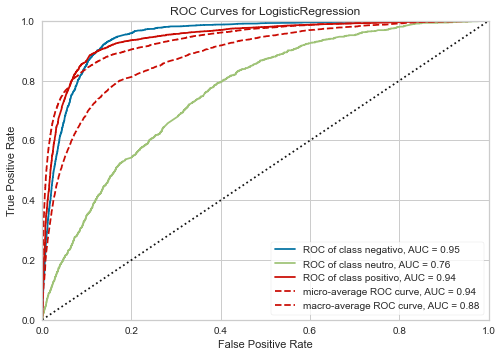

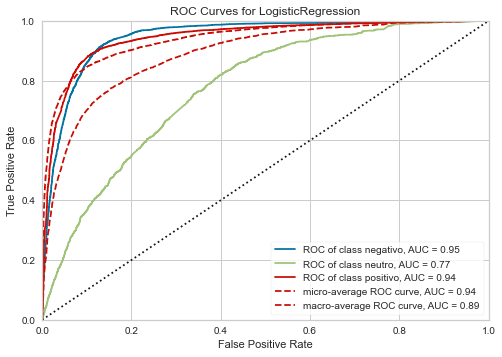

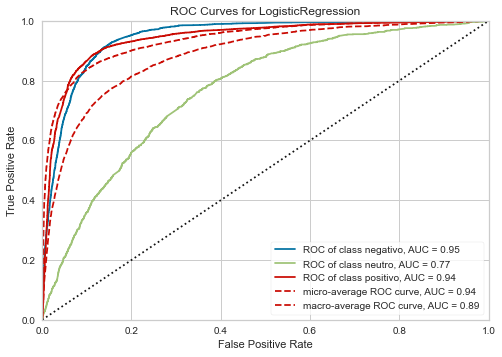

In [24]:
# Atribuindo a X o valor que foi processado pelo Pipeline
X = X_processed

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)
i = 1

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(penalty='l1',C=0.5151918020836844, class_weight='balanced', solver='liblinear', max_iter=100)

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    
    plt.figure(i)
    visualizer = ROCAUC(regressao_logistica)

    visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show()                       # Finalize and render the figure
    i += i

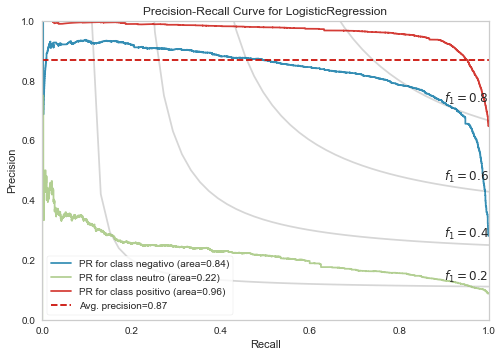

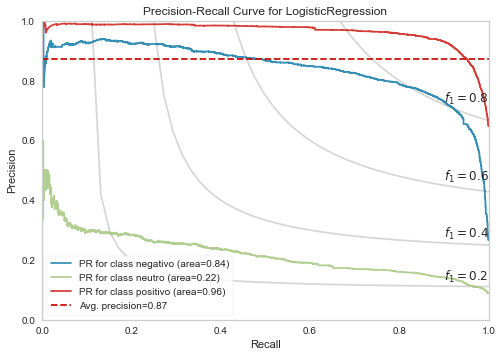

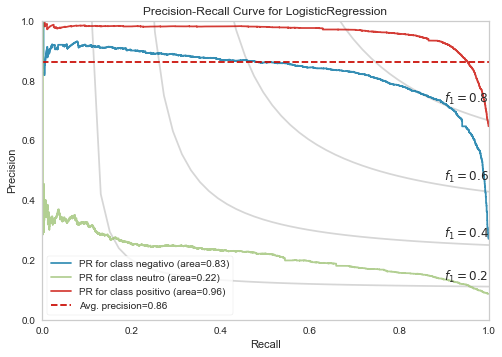

In [19]:
# Atribuindo a X o valor que foi processado pelo Pipeline
X = X_processed
encoder = LabelEncoder()
y_encoder = encoder.fit_transform(y)

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y_encoder)
i = 1

for train_index, test_index in skf.split(X, y_encoder):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoder[train_index], y_encoder[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(penalty='l1',C=0.5151918020836844, class_weight='balanced', solver='liblinear', max_iter=100)

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    
    plt.figure(i)
    # Create the visualizer, fit, score, and show it
    viz = PrecisionRecallCurve(
        regressao_logistica,
        classes=encoder.classes_,
            iso_f1_curves=True,
            per_class=True,
            micro=False
    )
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()                     # Finalize and render the figure
    i += i

É possível visualizar grande diferença entre as curvas, em especial a curva da classe "neutro". A ROC da classe "neutro" possui um crescimento bem mais lento, se comparada as outras classes, onde os verdadeiros positivos só se aproximam do máximo quando os falsos positivos assumem valores altos. Na curva Precision-Recall, vemos também o comportamento pior da curva representada pela classe "neutra". 

### 7.2. SVM (Support Vector Machines)

Uma Máquina de Vetores de Suporte (SVM) é um modelo muito poderoso e versátil de Aprendizado de Máquina capaz de realizar classificações lineares ou não lineares, de regressão e até mesmo detecção de outliers. As SVM são particularmente adequadas para a classificação de conjuntos de dados complexos. Dentro da modulo SVM iremos utilizar a classe SVC (C-Support Vector Classification.), no qual o suporte multiclasse é tratado de acordo com um esquema de um contra um.

Hiperparâmetro:
- C: Parâmetro de regularização. Um valor menor de C leva a uma via mais larga, mas com mais violações das margens.
- kernel: Especifica o tipo de kernel a ser usado no algoritmo. 
- coef0: controla o quanto o modelo é influenciado por polinômios de alto grau versus polinômios de baixo grau. Só é significativo em 'poli' e 'sigmóide'.
- gamma: Coeficiente de kernel para 'rbf', 'poli' e 'sigmoid'.
    - Se gamma='scale'(padrão) for passado, ele usará 1 / (n_features * X.var()) como valor de gama,
    - Se 'auto', usa 1 / n_features.


#### 7.2.1. Otimização para Tf-id pelo GridSearchCV

In [21]:
# Hiperparâmentros
tuned_parameters = {
    'C': [1.0],
    'kernel' : ['rbf'],
    'gamma': ['scale', 'auto'] 
}

model_SVC = SVC()

print_score(model_SVC, X_processed, y, tuned_parameters)

# Ajustando hiperparâmetros para make_scorer(f1_score, average=weighted)

Melhor conjunto de parâmetros encontrado: 

{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.819 (+/-0.010) for {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.678 (+/-0.023) for {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.75      0.89      0.81      2151
      neutro       0.27      0.02      0.04       730
    positivo       0.89      0.94      0.92      5315

    accuracy                           0.84      8196
   macro avg       0.64      0.62      0.59      8196
weighted avg       0.80      0.84      0.81      8196



Em uma primeira analise com o classificador SVC houve uma pequena melhora na classificação das classes 'negativo' e 'positivo', enquanto a classe 'neutro' piorou significativamente, se comparada com o melhor modelo de LogisticRegression. O custo computacional para o classificador SVC foi muito superior. A classe 'neutra' se manteve como a pior classe na classificação dos reveiws, se comparado com o modelo de LogisticRegression, teve uma queda de 0.09 em f1-score e 0.06 no recall. 

Iremos verificar o aumento do valor de 'C' e a definição do valor de 'gama' manualmente. O alto valor de C faz o classificador possuir menos violações na margem, mas fica com uma margem menor. Aumentar ‘gamma’ estreitará a curva em forma de sino, e como resultado cada raio de influência da instância será menor: mexer ao redor de instâncias individuais torna a fronteira de decisão mais irregular. Por outro lado, um pequeno valor de ‘gamma’ torna a curva em forma de sino mais ampla, de modo que as instâncias ficam com um maior raio de influência e o limite de decisão fica mais suave.


In [23]:
# Hiperparâmentros
tuned_parameters = {
    'C': [1.0, 100],
    'kernel' : ['rbf'],
    'gamma': [0.1, 10] 
}

model_SVC = SVC()

print_score(model_SVC, X_processed, y, tuned_parameters)

# Ajustando hiperparâmetros para make_scorer(f1_score, average=weighted)

Melhor conjunto de parâmetros encontrado: 

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.807 (+/-0.003) for {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.580 (+/-0.014) for {'C': 1.0, 'gamma': 10, 'kernel': 'rbf'}
0.825 (+/-0.003) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.586 (+/-0.012) for {'C': 100, 'gamma': 10, 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.76      0.87      0.81      2151
      neutro       0.32      0.10      0.15       730
    positivo       0.90      0.93      0.92      5315

    accuracy                           0.84      8196
   macro avg       0.66      0.63      0.63      8196
weighted avg       0.81      0.84      0.82      8196



A variação dos hiperparâmetros resultou em uma excelente melhora no modelo de classificação em todas as classes chegando a superar o melhor modelo de LogisticRegression. Em especial houve melhora na classe 'neutro', nas métricas recall e f1-score.

Como o melhor modelo encontrado possui um valor alto de do hiperparâmetros 'C', vamos verificar se aumentando ainda mais seu valor melhora o resultado da classificação:

In [20]:
# Hiperparâmentros
tuned_parameters = {
    'C': [200, 300],
    'kernel' : ['rbf'],
    'gamma': [0.1] 
}

model_SVC = SVC()

print_score(model_SVC, X_processed, y, tuned_parameters)

# Ajustando hiperparâmetros para make_scorer(f1_score, average=weighted)

Melhor conjunto de parâmetros encontrado: 

{'C': 200, 'gamma': 0.1, 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.823 (+/-0.006) for {'C': 200, 'gamma': 0.1, 'kernel': 'rbf'}
0.820 (+/-0.006) for {'C': 300, 'gamma': 0.1, 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.76      0.84      0.80      2151
      neutro       0.25      0.10      0.15       730
    positivo       0.90      0.93      0.91      5315

    accuracy                           0.83      8196
   macro avg       0.63      0.62      0.62      8196
weighted avg       0.80      0.83      0.81      8196



O grande aumento do hiperparâmetro 'C' não resultou em melhora do modelo, mas resultou em um valor de f1-score bastante próximo do melhor modelo encontrodado. Então vamos verificar um valor de 'C' mais próximo de 100 (valor do melhor classificado):

In [21]:
# Hiperparâmentros
tuned_parameters = {
    'C': [125, 175],
    'kernel' : ['rbf'],
    'gamma': [0.1, 1] 
}

model_SVC = SVC()

print_score(model_SVC, X_processed, y, tuned_parameters)

# Ajustando hiperparâmetros para make_scorer(f1_score, average=weighted)

Melhor conjunto de parâmetros encontrado: 

{'C': 125, 'gamma': 0.1, 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.823 (+/-0.005) for {'C': 125, 'gamma': 0.1, 'kernel': 'rbf'}
0.821 (+/-0.004) for {'C': 125, 'gamma': 1, 'kernel': 'rbf'}
0.823 (+/-0.005) for {'C': 175, 'gamma': 0.1, 'kernel': 'rbf'}
0.821 (+/-0.004) for {'C': 175, 'gamma': 1, 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.76      0.86      0.81      2151
      neutro       0.30      0.10      0.15       730
    positivo       0.90      0.93      0.91      5315

    accuracy                           0.84      8196
   macro avg       0.65      0.63      0.63      8196
weighted avg       0.81      0.84      0.82      8196



In [19]:
# Hiperparâmentros
tuned_parameters = {
    'C': [110, 112],
    'kernel' : ['rbf'],
    'gamma': [0.1] 
}

model_SVC = SVC()

print_score(model_SVC, X_processed, y, tuned_parameters)

# Ajustando hiperparâmetros para make_scorer(f1_score, average=weighted)

Melhor conjunto de parâmetros encontrado: 

{'C': 110, 'gamma': 0.1, 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.823 (+/-0.001) for {'C': 110, 'gamma': 0.1, 'kernel': 'rbf'}
0.823 (+/-0.002) for {'C': 112, 'gamma': 0.1, 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.76      0.87      0.81      2151
      neutro       0.32      0.10      0.15       730
    positivo       0.90      0.93      0.92      5315

    accuracy                           0.84      8196
   macro avg       0.66      0.63      0.63      8196
weighted avg       0.81      0.84      0.82      8196



Os resultados obtidos foram bastante similar com o modelo de parâmentros igual {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}. O valor de f1-score foi menor que 0.825 (+/-0.003), mas o desvio padrão foi menor (+/-0.001) para os três valores calculados para Cross-Validation.

O melhor modelo para o SVC selecionado será:

In [25]:
# Hiperparâmentros
tuned_parameters = {
    'C': [110],
    'kernel' : ['rbf'],
    'gamma': [0.1] 
}

model_SVC = SVC()
incial = time()
print_score(model_SVC, X_processed, y, tuned_parameters)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros para make_scorer(f1_score, average=weighted)

Melhor conjunto de parâmetros encontrado: 

{'C': 110, 'gamma': 0.1, 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.824 (+/-0.003) for {'C': 110, 'gamma': 0.1, 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.76      0.87      0.81      2151
      neutro       0.32      0.10      0.15       730
    positivo       0.90      0.93      0.92      5315

    accuracy                           0.84      8196
   macro avg       0.66      0.63      0.63      8196
weighted avg       0.81      0.84      0.82      8196

Tempo de execução: 46.78752770423889min


#### 7.2.2. Otimização para Tf-id pelo BayesSearchCV

In [18]:
 # log-uniform: understand as search over p = exp(x) by varying x

search_spaces=[{
    'C': Real(1e-3, 1e+3, prior='log-uniform'),
    'kernel' : Categorical(['rbf']),
    'gamma': Real(0.1, 10, prior='log-uniform') 
}]

model = SVC()
n_iter = 50
incial = time()
print_score_BayesSearchCV(model, X_processed, y, search_spaces, n_iter)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros: 

Melhor conjunto de parâmetros encontrado: 

OrderedDict([('C', 5.114312906246165), ('gamma', 0.7052207811078224), ('kernel', 'rbf')])
f1_score (weighted): 0.8245544917624398

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.76      0.86      0.81      2151
      neutro       0.28      0.08      0.13       730
    positivo       0.90      0.93      0.91      5315

    accuracy                           0.84      8196
   macro avg       0.64      0.63      0.62      8196
weighted avg       0.80      0.84      0.82      8196

Tempo de execução: 670.8822413841883min


#### 7.2.3. Otimização para CountVectorezer pelo GridSearchCV

Devido a otimização por BayesSearchCV ser muito custosa e não obtive resultados satisfatorios se copmarados com os testes indivuais com O GridSearchCV, vamos utilizar apenas o GridSearchCV para uma rápida comparação com o método TF-id

In [15]:
# Hiperparâmentros
tuned_parameters = {
    'C': [1, 50, 100],
    'kernel' : ['rbf'],
    'gamma': [0.1, 5] 
}

model_SVC = SVC()
incial = time()
print_score(model_SVC, X_processed_countvec, y, tuned_parameters)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros para make_scorer(f1_score, average=weighted)

Melhor conjunto de parâmetros encontrado: 

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.808 (+/-0.002) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.582 (+/-0.016) for {'C': 1, 'gamma': 5, 'kernel': 'rbf'}
0.805 (+/-0.003) for {'C': 50, 'gamma': 0.1, 'kernel': 'rbf'}
0.582 (+/-0.016) for {'C': 50, 'gamma': 5, 'kernel': 'rbf'}
0.799 (+/-0.003) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.582 (+/-0.016) for {'C': 100, 'gamma': 5, 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.74      0.87      0.80      2151
      neutro       0.17      0.01      0.01       730
    positivo       0.88      0.94      0.91      5315

    accuracy                           0.84      8196
   macro avg       0.60      0.61      0.57      8196
weighted avg       0.78      0.84  

#### 7.2.2. Analizando as curvas ROC e Precision-Recall para o melhor de SVC

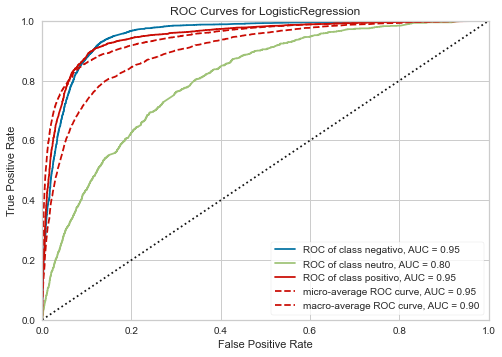

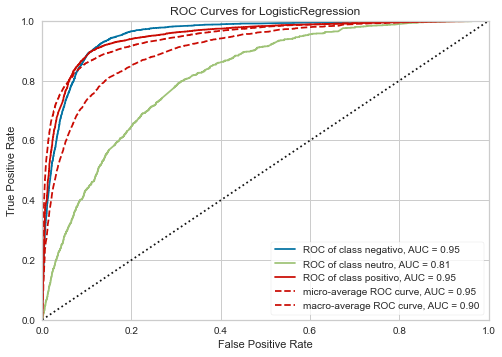

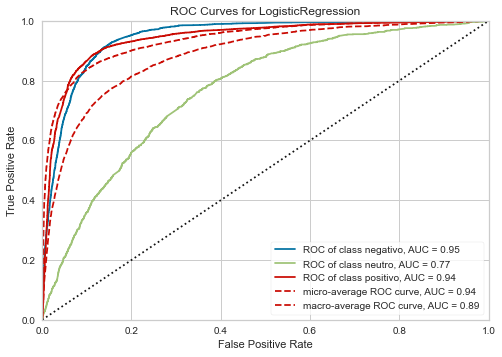

In [25]:
# Atribuindo a X o valor que foi processado pelo Pipeline
X = X_processed

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)
i = 1

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Criação do modelo
    model = SVC(gamma=0.1, C=110, kernel='rbf')

    model.fit(X_train, y_train)
    y_true, y_pred = y_test, model.predict(X_test)
    
    plt.figure(i)
    visualizer = ROCAUC(regressao_logistica)

    visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show()                       # Finalize and render the figure
    i += i

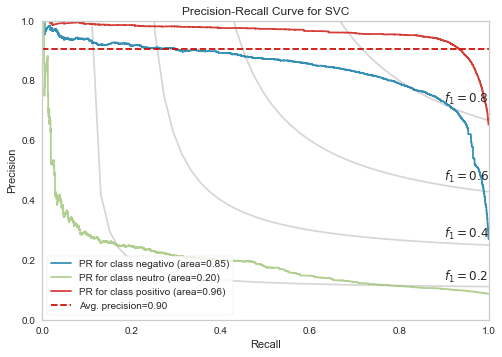

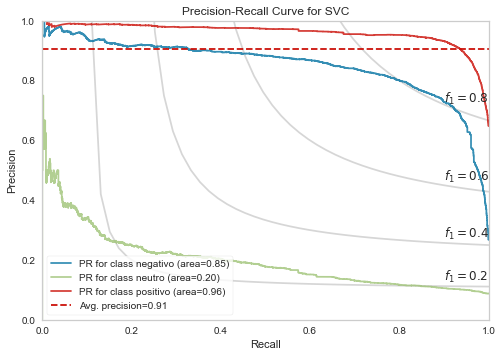

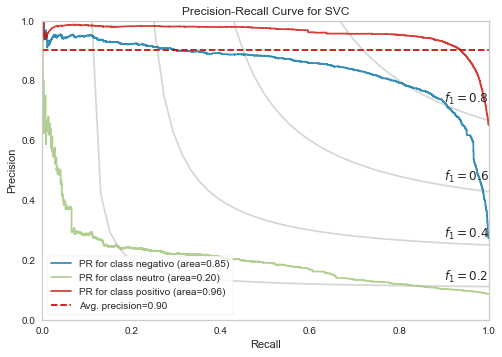

In [20]:
# Atribuindo a X o valor que foi processado pelo Pipeline
X = X_processed
encoder = LabelEncoder()
y_encoder = encoder.fit_transform(y)

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y_encoder)
i = 1

for train_index, test_index in skf.split(X, y_encoder):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoder[train_index], y_encoder[test_index]

    #Criação do modelo
    model = SVC(gamma=0.1, C=110, kernel='rbf')

    model.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    
    plt.figure(i)
    # Create the visualizer, fit, score, and show it
    viz = PrecisionRecallCurve(
        model,
        classes=encoder.classes_,
        iso_f1_curves=True,
        per_class=True,
        micro=False
    )
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()                     # Finalize and render the figure
    i += i

Assim como para o modelo de LogisticRegression, o modelo de SVC possui o mesmo comportamento. A ROC da classe "neutro" possui um crescimento bem mais lento, se comparada as outras classes. Comparando o modelo de LogisticRegression com o SVC. A curva ROC para a classe "neutro" possui um crescimento um pouco mais rápido, mas nada que seja tão significante. Em relação a curva Precision-Recall, vemos também o mesmo comportamento das classes. 

## 8. Conclusão 

Após verificar todas as métricas (precision,recall e f1-score) e o plot das curvas (ROC e PrecisionRecallCurve) verificamos que para esta série de tratamentos e tecnicas realizados ao conjunto de dados a classificação da classe "Neutro" não assume valores bons suficientes para validar o modelo. 

Este projeto foi apresentado para um especilista da área de NPL, onde ele sugeriu modificações no tratamento dos dados e alterações de algumas tecnicas realizadas ao longo do projeto. A seguir estão descritas as sugestões que serão empregadas em um novo arquivo (2_analise_sentimento):

- Aplicar processo de Stemming em vez de Lammatization;
- Remover 10% dos dados que mais aparecem e que menos aparecem;
- Incluir filtro de Pos Tag;
- Aplicar tecnicas de UnderSampling.